# Import and functions

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
import pandas as pd
import os
import math


%matplotlib inline

In [96]:
import import_ipynb
try:
    os.chdir('Modules')
except:
   os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
    
from time_shifted_PID import MIfunc
from Spike_Generation import SG

In [97]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

# NGD

In [98]:
m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

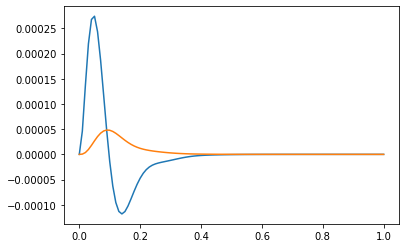

In [99]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

In [100]:
tot = 300
tAxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(tAxis))
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [101]:
contrast = 0.3
mean = 10
baseOutput = -np.convolve(np.hstack((np.zeros(len(k_E)), x))*contrast*mean+mean, k_E, 'full')[:len(k_E)+len(x)]

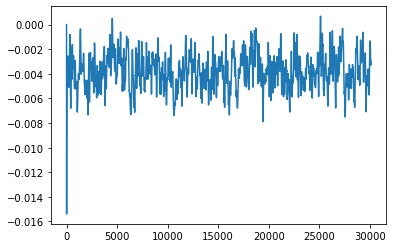

In [102]:
plt.plot(baseOutput)

In [103]:
theta_star = 0

baseOutputRange = 0.005 

In [117]:
rstate = SG (baseOutput[len(k_E):], dt, theta_star, 10, 2)
theta = np.mean(baseOutput[len(k_E):])+theta_star*np.std(baseOutput[len(k_E):])

# GC

In [104]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

In [105]:
B = 3000 #To tune altitude of gain control (D=1/T)
tau = 0.1

2993


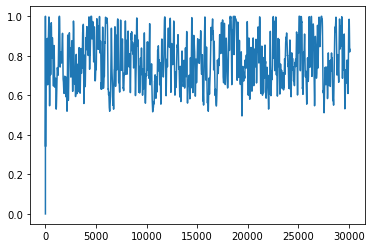

In [106]:
GC_output, gain = AddGainControl(-baseOutput, B, tau) # GC after rectifier
plt.plot(gain) # make sure the value of gain is good
GC_output = -GC_output[len(k_E):]

GC_rstate = SG (GC_output, dt, theta_star, 10, 2)
GC_theta = np.mean(GC_output)+theta_star*np.std(GC_output)
print(np.sum(GC_rstate))

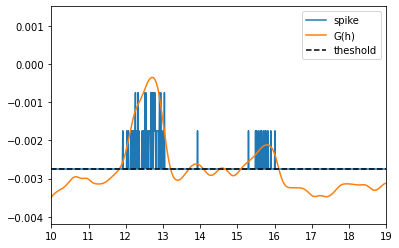

In [107]:
plt.plot(tAxis,GC_rstate*baseOutputRange/5+GC_theta, label = 'spike')

# plt.plot(tAxis,baseOutput, label = 'h')
plt.plot(tAxis,GC_output, label = 'G(h)')

plt.plot(tAxis,np.ones_like(GC_output)*GC_theta, 'k--', label = 'theshold')
plt.xlim(10,19)
plt.legend()

# SFB

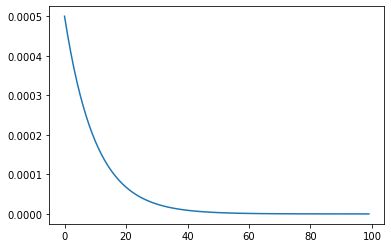

In [108]:
tau_P = 0.1 #s
sigma_b = baseOutputRange*0.1
expDecay = np.exp(-np.arange(0,1,dt)/tau_P)*sigma_b
plt.plot(expDecay)

In [109]:
def SFB(input, expDecay, theta):
    test = 0
    h = input.copy()
    rstate = np.zeros_like(baseOutput)
    for i in range(len(h)):
        while h[i] > theta:
            rstate[i] += 1
            h[i:min(i+len(expDecay),len(h))] -= expDecay[:min(len(expDecay),len(h)-i)]
    return rstate, h

In [110]:
SFB_theta = np.mean(baseOutput)+theta_star*np.std(baseOutput)
rstate, h = SFB(baseOutput, expDecay, SFB_theta)

SFB_rstate = rstate[len(k_E):]
SFB_h = h[len(k_E):]

print(np.sum(rstate))

3972.0


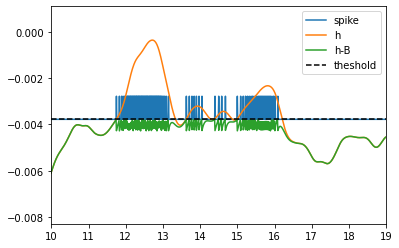

In [111]:
plt.plot(tAxis,SFB_rstate*baseOutputRange/5+SFB_theta, label = 'spike')

plt.plot(tAxis,baseOutput[len(k_E):], label = 'h')
# plt.plot(tAxis,GC_output, label = 'G(h)')
plt.plot(tAxis,SFB_h, label = 'h-B')
plt.plot(tAxis,np.ones_like(SFB_rstate)*SFB_theta, 'k--', label = 'theshold')
plt.xlim(10,19)
plt.legend()

(10.0, 19.0)

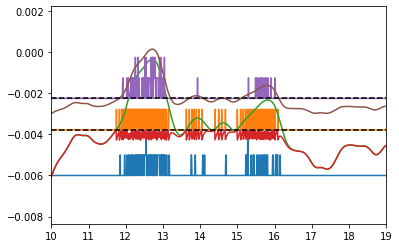

In [119]:
plt.plot(tAxis,rstate*baseOutputRange/5-0.006, label = 'spike')

plt.plot(tAxis,SFB_rstate*baseOutputRange/5+SFB_theta , label = 'spike')

plt.plot(tAxis,baseOutput[len(k_E):], label = 'h')
plt.plot(tAxis,SFB_h, label = 'h-B')
plt.plot(tAxis,np.ones_like(SFB_rstate)*SFB_theta, 'k--', label = 'theshold')


plt.plot(tAxis,GC_rstate*baseOutputRange/5+GC_theta +0.0005, label = 'spike')
plt.plot(tAxis,GC_output+0.0005, label = 'G(h)')

plt.plot(tAxis,np.ones_like(GC_output)*GC_theta+0.0005, 'k--', label = 'theshold')
plt.xlim(10,19)
# plt.legend()

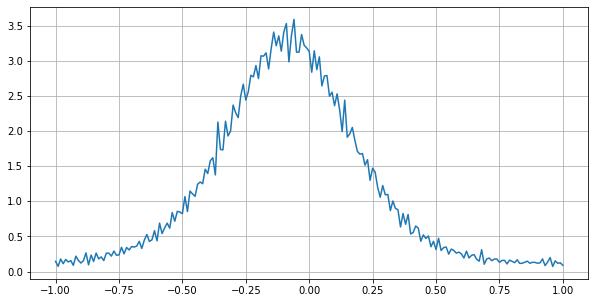

In [121]:
timeshift, MI = MIfunc(rstate, SFB_rstate, dt, [-1,1])
plt.plot(timeshift,MI)
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# LNK

In [114]:
# # four states kinetic model
# # using the same notation as Ozuysal
# # Eqn(11) in "Experimental Procedure" section

# def kinetic(u,para,dt):
#     ka  = para[0]
#     kfr = para[1]
#     kfi = para[2]
#     ksr = para[3]
#     ksi = para[4]
# #   initial conditions for the four states
#     p1 = 1.0
#     p2 = 0
#     p3 = 0.0
#     p4 = 0.0

#     p1r = []
#     p2r = []
#     p3r = []
#     p4r = []
# #
# # 
# #
#     for i in range(len(u)):
#         dp1 = (-u[i]*ka*p1  + kfr*p3)*dt
#         dp2 =  (u[i]*ka*p1     - kfi*p2)*dt
#         dp3 =  (kfi*p2 - (kfr+ksi)*p3 + u[i]*ksr*p4)*dt
#         dp4 =  (ksi*p3 - u[i]*ksr*p4)*dt
    
#         p1 = p1 + dp1
#         p2 = p2 + dp2
#         p3 = p3 + dp3
#         p4 = p4 + dp4
    
#         p1r.append(p1)
#         p2r.append(p2)
#         p3r.append(p3)
#         p4r.append(p4)
        
# # turn list into numpy arrays
#     p1r = np.array(p1r)
#     p2r = np.array(p2r)
#     p3r = np.array(p3r)
#     p4r = np.array(p4r)
#     return (p1r,p2r,p3r,p4r)

In [115]:
# Nonlinearity function
# midpoint = 0.25 # position of the mid point of the nonlinear function (tanh)
# DR = 5 # dynamical range (?) of the nonlinear function (tanh)
# dummy = np.linspace(-1,1,1000)
# plt.plot(dummy, (np.tanh((dummy-midpoint)*DR)+1)/2)

In [116]:
# # testing of u from g
# u = (np.tanh((g-midpoint)*DR)+1)/2
# plt.plot(g)
# plt.plot(u)
# plt.xlim(0,5000)